# Example scVI run on a PBMC dataset

2024.03.26

Run scVI using Cellarium ML and explore the outputs.

In [1]:
# your config file for running scVI
import os
config_file = "../example_configs/scvi_pbmc_config.yaml"
#script_dir = os.path.dirname(os.path.abspath(__file__))
os.path.abspath('')
import sys
sys.path.append("../..") # go to parent dir
print(os.getcwd())

/tmp/620118ae-073f-4593-b3ec-ab737d3e8251/cellarium-ml/notebooks


## Run scVI

In [2]:
#!cellarium-ml scvi fit --config {config_file}
!/opt/conda/bin/python ../cellarium/ml/cli.py scvi fit -c {config_file}

/opt/conda/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py:40: No seed found, seed set to 0
Seed set to 0
/tmp/4c300876-bd77-425a-8f1c-2362ac05a30c/cellarium-ml/cellarium/ml/utilities/data.py:160: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  collated_batch[key] = torch.cat([torch.from_numpy(data[key]) for data in batch], dim=0)
SingleCellVariationalInference(
  (z_encoder): EncoderSCVI(
    (fully_connected): FullyConnectedWithBatchArchitecture(
      (module_list): ModuleList(
        (0): DressedLayer(
          (layer): LinearWithBatch(
            in_featur

## Load model

In [25]:
# your latest checkpoint file (you'll need to look for it)

checkpoint_file = 'lightning_logs/version_24/checkpoints/epoch=49-step=3150.ckpt'

In [3]:
from notebooks_functions import get_dataset_from_anndata, embed
import torch
import scanpy as sc
import yaml
from cellarium.ml.core import CellariumPipeline, CellariumModule

In [ ]:
# load the trained model
scvi_model = CellariumModule.load_from_checkpoint(checkpoint_file).model

# move the model to the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
scvi_model.to(device)
scvi_model.eval()

# construct the pipeline
pipeline = CellariumPipeline([scvi_model])

In [6]:
# get the location of the dataset
with open(config_file, "r") as file:
    config_dict = yaml.safe_load(file)
data_path = config_dict['data']['dadc']['init_args']['filenames']
print(f'Data is coming from {data_path}')

# get a dataset object
dataset = get_dataset_from_anndata(
    data_path, 
    batch_size=128, 
    shuffle=False, 
    seed=0, 
    drop_last=False,
)

Data is coming from gs://yx-data/pbmc_count.h5ad


In [8]:
adata = embed(dataset, pipeline,device= device)

/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(


  0%|          | 0/249 [00:00<?, ?it/s]/tmp/ipykernel_79334/1887292182.py:32: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  batch['batch_index_n'] = torch.from_numpy(batch['batch_index_n']).to(device)
100%|██████████| 249/249 [00:08<00:00, 29.61it/s]


In [9]:
adata

AnnData object with n_obs × n_vars = 31774 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'
    obsm: 'X_scvi'

# Visualizations

In [10]:
sc.set_figure_params(fontsize=14, vector_friendly=True)

## Before scVI

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=15, metric='euclidean', method='umap')
sc.tl.umap(adata)
adata.obsm['X_raw_umap'] = adata.obsm['X_umap'].copy()

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


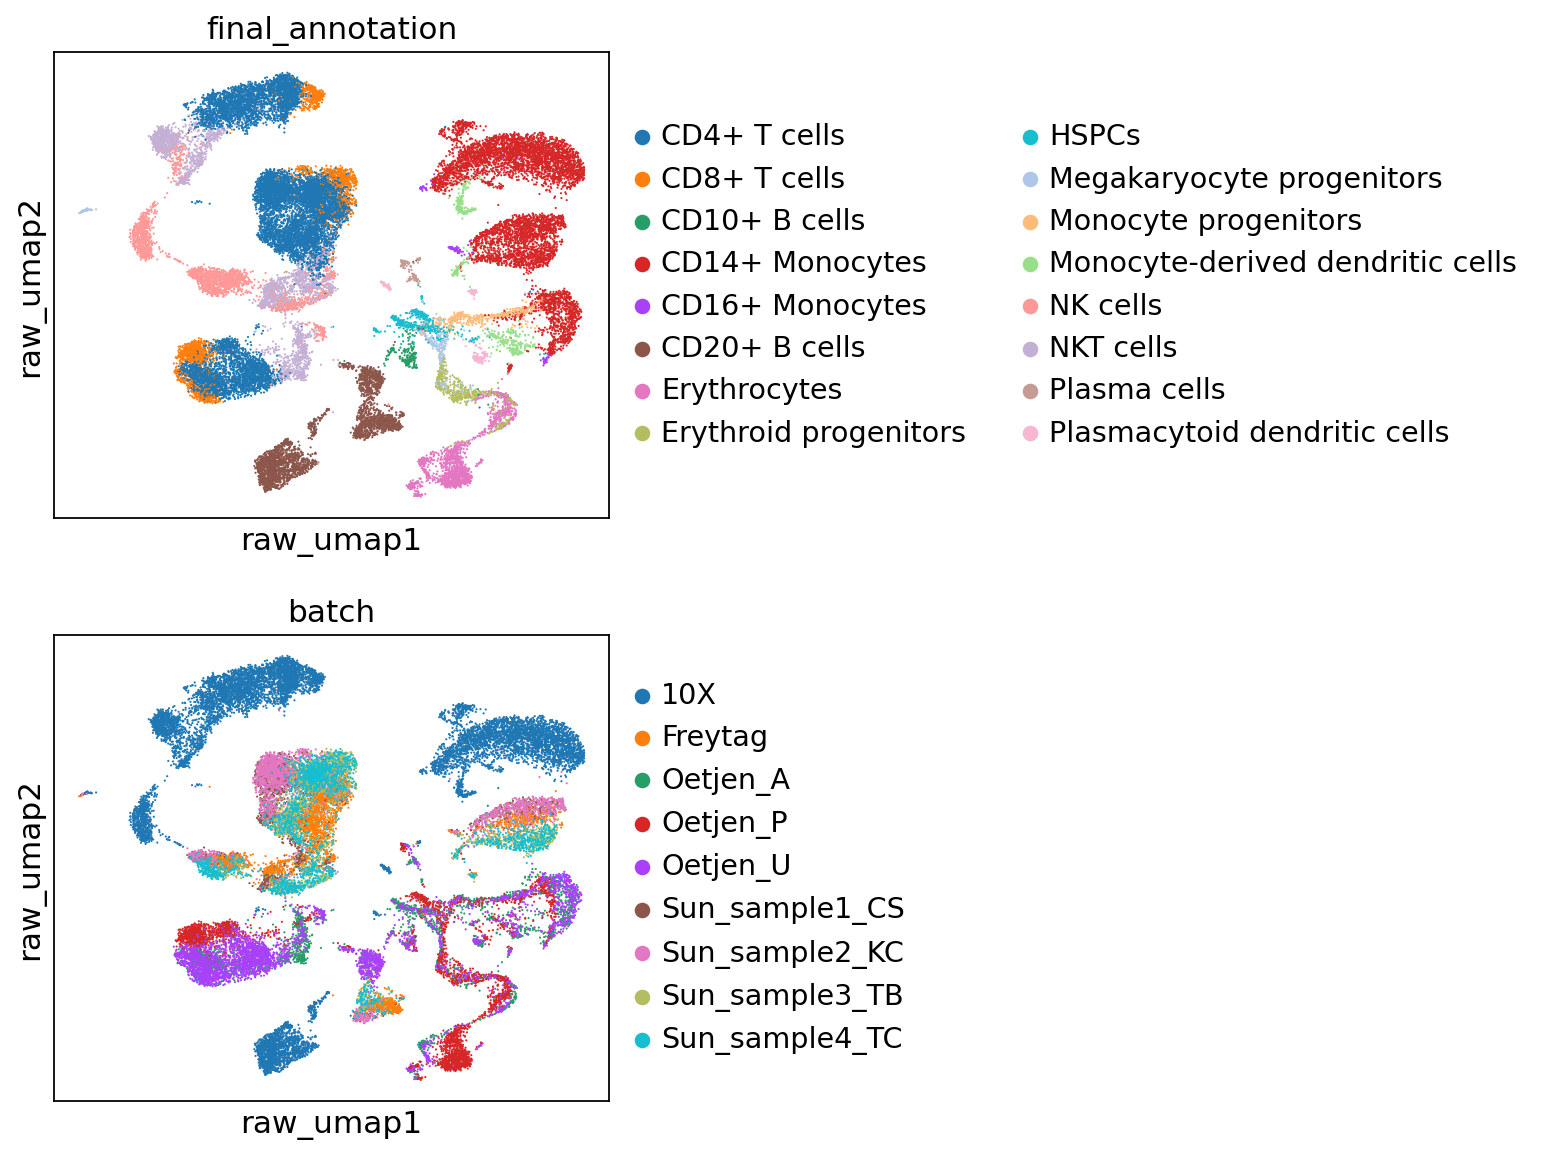

In [12]:
sc.pl.embedding(adata, basis='raw_umap', color=['final_annotation', 'batch'], ncols=1)

## After scVI

In [13]:
sc.pp.neighbors(adata, use_rep='X_scvi', n_neighbors=15, metric='euclidean', method='umap')
sc.tl.umap(adata)
adata.obsm['X_scvi_umap'] = adata.obsm['X_umap'].copy()

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


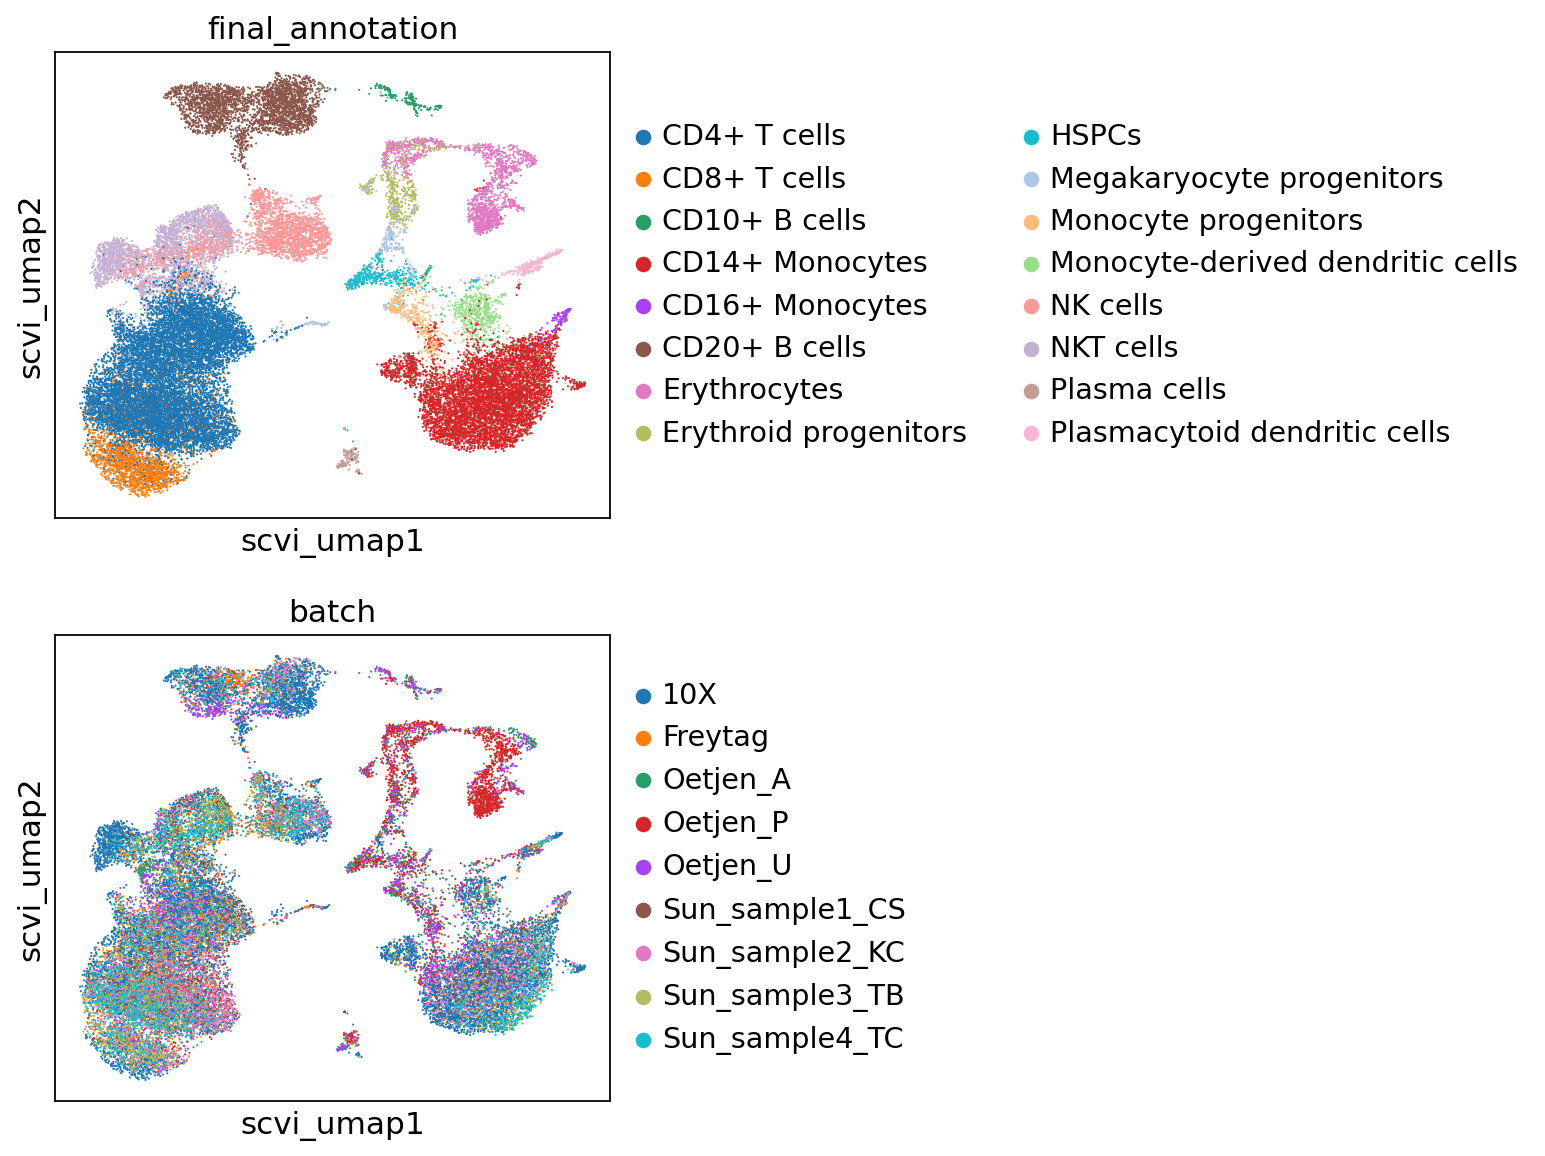

In [14]:
sc.pl.embedding(adata, basis='scvi_umap', color=['final_annotation', 'batch'], ncols=1)